# New Dataset Face Detection

In [5]:
# loading libraries
# System
import os
import joblib
from collections import Counter

# Image processing
import skimage
from skimage.transform import resize
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

# Data Processing
import numpy as np
import pandas as pd

# data viz
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [6]:
# load function
from resizedata import resize_data

In [7]:
data_path2 = r'C:\Users\straw\Desktop\AIS\ProjectPool 2\Classification-images\Data\raw-img'
print(os.listdir(data_path2))

['ButterflyHead', 'CatHead', 'ChickenHead', 'CowHead', 'DogHead', 'ElephantHead', 'HorseHead', 'SheepHead', 'SquirrelHead']


In [8]:
pklname2 = 'output2'

In [11]:
width = 80
include2 = {'ButterflyHead', 'CatHead', 'ElephantHead', 'DogHead', 'HorseHead', 'SheepHead', 'CowHead'}

In [12]:
#resize_data(path=data_path2, pklname=pklname2, include=include2, width=width)

{'description': 'resized (80x80)animal images in rgb',
 'label': ['Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'Butterfly',
  'But

In [13]:
data2 = joblib.load(f'Output/{pklname2}_{width}x{width}px.pkl')
 
print('Number of samples: ', len(data2['data']))
print('Keys: ', list(data2.keys()))
print('Description: ', data2['description'])
print('Images shape: ', data2['data'][0].shape)
print('Labels:', np.unique(data2['label']))

Number of samples:  16398
Keys:  ['description', 'label', 'filename', 'data']
Description:  resized (80x80)animal images in rgb
Images shape:  (80, 80, 3)
Labels: ['Butterfly' 'Cat' 'Cow' 'Dog' 'Elephant' 'Horse' 'Sheep']


In [14]:
Counter(data2['label'])

Counter({'Butterfly': 2112,
         'Cat': 1668,
         'Cow': 1866,
         'Dog': 4863,
         'Elephant': 1446,
         'Horse': 2623,
         'Sheep': 1820})

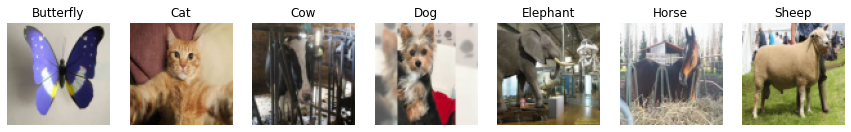

In [15]:
labels = np.unique(data2['label'])

fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,15)
for ax, label in zip(axes, labels):
    idx = data2['label'].index(label)
    ax.imshow(data2['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [19]:
l = []
for i in range(0, len(data2['data'])):
    if data2['data'][i].shape != (80, 80, 3):
        l.append(i)
print(l)

[2, 5, 128, 251, 374, 497, 620, 743, 817, 840, 863, 886, 889, 912, 935, 958, 981, 1004, 1027, 1050, 1073, 1096, 1119, 1122, 1145, 1168, 1191, 1214, 1237, 1260, 1283, 1306, 1329, 1352, 1355, 1499, 1622, 1745, 1991, 2114, 10511, 10814, 10904, 11037, 11220, 11343, 11466, 11589, 11712]


In [20]:
for e in l:
    data2['data'].pop(e)
    data2['label'].pop(e)

In [21]:
X_bis = np.array(data2['data'])
y_bis = np.array(data2['label'])

<ipython-input-21-e52ea713d1f1>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



ValueError: could not broadcast input array from shape (80,80,3) into shape (80,80)

In [ ]:
X_train_bis, X_test_bis, y_train_bis, y_test_bis = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [ ]:
print(Counter(y))
print(Counter(y_train_bis))
print(Counter(y_test_bis))